# SP

In [1]:
from SignalProcessing import RangeCompression,DopplerProcessing,CFAR, Clustering
import Dataloader
import Plot
import numpy as np
from mmwave import dsp
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns; 
from matplotlib.colors import  LogNorm
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from scipy import constants
from scipy import ndimage
from PIL import Image, ImageFilter
from scipy.ndimage import convolve1d

from collections import deque

from operator import itemgetter
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
no_reflector = "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin"
best_restult = "felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin"
munkholm = "felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin"

In [3]:
data_IF =Dataloader.LoadData("best_restult.npy")

In [4]:
old=  RangeCompression.RangeCompression(data_IF[100,0],axis=1)
old, _ = DopplerProcessing.DopplerProcessing(old, axis=0,isClutterRemoval=True, removeArtifacts=False)
old= np.abs(old)

In [5]:
def P_avg(P,N):
    return P
def alpha(N,P_FA):
    return(P_FA**(-1/N)-1)

def estimated_teshold(alpha,P):
    return alpha*np.abs(P)


def CFAR_1D(data, guard_cells, training_cells, PFA):
    
    
    window_size = guard_cells + training_cells
    
    window_area = (2*window_size+1)**2
    training_area = training_cells*2
    a = alpha(training_area, PFA)

    kernel = np.ones((1 + (2 * guard_cells) + (2 * training_cells)), dtype=data.dtype)
    kernel[training_cells:training_cells + (2 * guard_cells) + 1] = 0
    
    res = convolve1d(data.copy(), kernel, mode='wrap')
    
    
    ret = (np.abs(data)>estimated_teshold(a,res))
    
    detections = np.argwhere(ret==True)
    #Transform cords to range and doppler
    #print(detections)
    

    detections = detections[detections[:,0] < 128,:] #delete all irelevant detections
    detections_cord =  detections.copy()
    detections[:,1] = detections[:,1]*0.785277
    detections[:,0] = (128-detections[:,0])*-0.12755
    
    det_tuples = [(i[1],i[0]) for i in detections] 

    
    
    

    
    
            
    return ret,data*ret,detections,detections_cord,det_tuples

In [6]:
#Remove arifacts
argArtifacts = np.nonzero(old >4*np.mean(old[:,50]))

In [10]:
def algorithm_cfar_1d(data,argArtifacts):
    range_cube =  RangeCompression.RangeCompression(data,axis=1)
    linear, mag = DopplerProcessing.DopplerProcessing(range_cube, axis=0,isClutterRemoval=True)
    
    linear[argArtifacts] = 1e-10
    detections_map,P_detections,detections, detections_cord,det_tuples = CFAR_1D(np.abs(linear).copy(), 4, 8, 0.01)
    return detections_map

In [13]:
cfar_arr=[]
for i in range(200,len(data_IF)):
    
    cfar_arr.append(algorithm_cfar_1d(data_IF[i,0],argArtifacts))

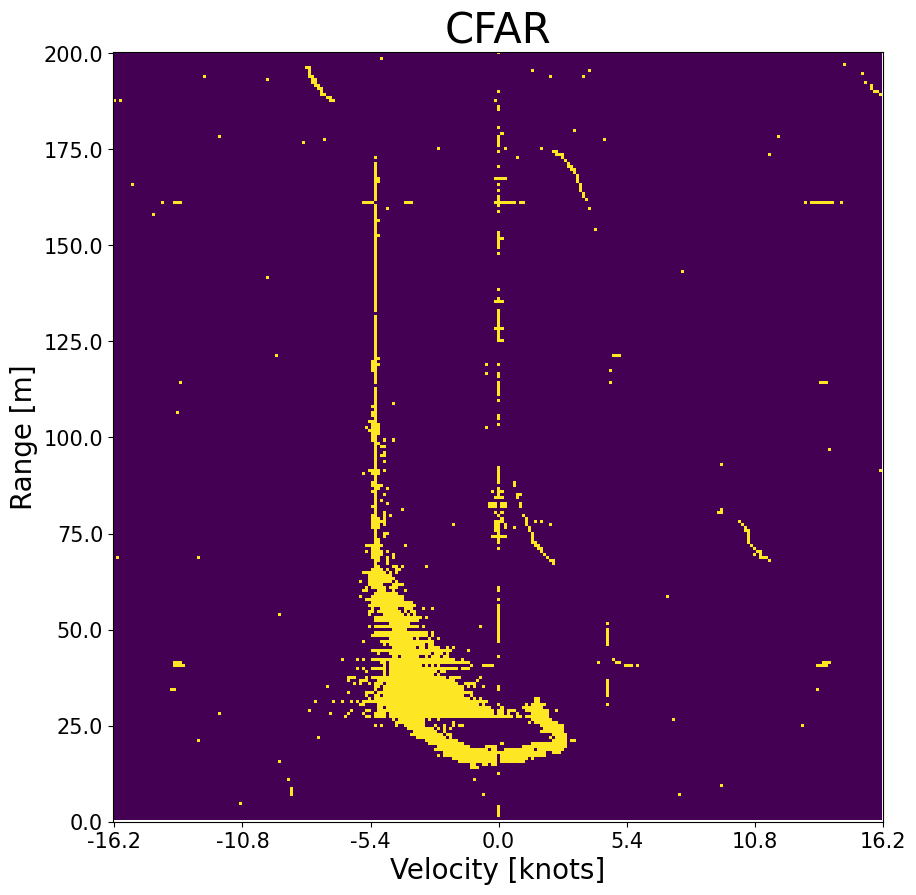

In [14]:
Plot.PlotCFAR(np.max(cfar_arr,axis=0))

# Tracking

In [ ]:
import numpy as np
from scipy.linalg import inv
import time

class KalmanFilter(object):
    def __init__(self, dt, x_init, P_init, Q, R):
        self.dt = dt  # time step
        self.x = x_init  # initial state (position, velocity)
        self.P = P_init  # initial covariance matrix
        self.Q = Q  # process noise covariance
        self.R = R  # measurement noise covariance

    def predict(self, u=None):
        
        F = np.array([[1, self.dt], [0, 1]])  # state transition matrix
        if u is not None:
            B = np.array([[(self.dt**2)/2], [self.dt]])  # control input matrix
            self.x = F @ self.x + B @ u
                      
        else:
            self.x = F @ self.x
            
        self.P = F @ self.P @ F.T + self.Q

    def update(self, z):
        H = np.array([[1, 0], [0, 1]])  # observation matrix
       
        y = z - H @ self.x  # innovation
        
        S = H @ self.P @ H.T + self.R  # innovation covariance
        
        K = self.P @ H.T @ inv(S)  # Kalman gain
        
        
        self.x = self.x + K @ y  # updated state estimate
        
        self.P = (np.eye(2) - K @ H) @ self.P  # updated covariance matrix


           


In [ ]:
def nearest_neighbor(observations, tracks, max_distance):
    """Performs nearest-neighbor data association between measurements and tracks.
    
    Parameters:
        observations (list): A list of observations in the form of (x, y) tuples.
        tracks (list): A list of tracks in the form of dictionaries, where each dictionary contains the following keys:
            - 'id': A unique identifier for the track.
            - 'x': The current x-coordinate of the track.
            - 'y': The current y-coordinate of the track.
        max_distance (float): The maximum distance between a measurement and a track for them to be associated.
    
    Returns:
        matches (list): A list of tuples in the form of (track_id, observation_index), where 'track_id' is the identifier
            of the associated track and 'observation_index' is the index of the associated observation in the 'observations' list.
        unmatched_tracks (list): A list of identifiers for tracks that did not have any associated observations.
        unmatched_observations (list): A list of indices for observations that did not have any associated tracks.
    """
    matches = []
    unmatched_tracks = []
    unmatched_observations = list(range(len(observations)))
    
    for track in tracks:
        
        min_distance = float('inf')
        min_index = -1
        
        for i, observation in enumerate(observations):
            min_index = -1
            
            distance = np.sqrt((tracks[track].x - observation[1])**2 + (tracks[track].vx - observation[0])**2)
            
            if distance < max_distance :
                min_distance = distance
                min_index = i
                
        
        if min_index >= 0:
            
            try:
                matches.append((tracks[track].track_id, min_index))
                unmatched_observations.remove(min_index)
            except:
                pass
            
            min_index = -1
        else:
            unmatched_tracks.append(tracks[track].track_id)
            min_index = -1
    
    return matches, unmatched_tracks, unmatched_observations

In [ ]:
class Track:
    """Class representing a track"""
    
    def __init__(self, track_id, x,  vx, kalman_filter,track_age, track_history ):
        self.track_id = track_id
        self.track_age = track_age
        self.x = x
        self.vx = vx
        self.kalman_filter = kalman_filter
        self.track_history = track_history

        
        
   
    
    def update(self, x, vx,hist):
        """Updates the state of the track with a new observation."""
        self.vx = vx
        self.x = x
        self.track_age += 1
        self.track_history.append(hist)
        if(len(self.track_history)>5):
            self.track_history.popleft()

    def __str__(self):
        return f"ID:{self.track_id}, Range:{self.x*0.785277}, V:{(128-self.vx)*-0.12755}"
        

In [ ]:
# Example usage
dt = 50*1e-3 # time step (in seconds)
x_init = np.array([[0], [5]])  # initial state (position, velocity)
P_init = np.diag([10, 10])  # initial covariance matrix

Q = np.diag([0.1, 0.1])  # process noise covariance
R = np.diag([[1,1],[1, 1]])  # measurement noise covariance

In [ ]:
def TrackMaintinance(tracks):
    detections = []
    delete_tracks = []
    for track in tracks:
        
        if(sum(tracks[track].track_history)/len(tracks[track].track_history) < 0.5 and len(tracks[track].track_history) > 3 ):
            delete_tracks.append(tracks[track].track_id)
        
        elif sum(tracks[track].track_history)>3 :
            detections.append(tracks[track])
    for track in delete_tracks:
        del tracks[track]
    return tracks,detections       
    

In [ ]:
q = deque([1,2,3])
print(sum(q))

6


In [ ]:
kf = KalmanFilter(dt, x_init, P_init, Q, R)
track_id = 0
# Process measurement data
tracks = {}
for t,detections in enumerate( cfar_arr):
    print(f"############### {t} ###############")
    matches, unmatched_tracks, unmatched_observations = nearest_neighbor(detections, tracks, 3)
    
    
    if(len(unmatched_observations)>0):
        for obs in unmatched_observations:
            
            track_id += 1
            kf = KalmanFilter(dt, np.array([detections[obs][1],detections[obs][0]]), P_init, Q, R)
            
            trk = Track(track_id, detections[obs][1], detections[obs][0], kf, 1, deque([1]))
            tracks[track_id] = trk
   
    if(len(matches)>0):
        for trk_id, obs in matches:
            tracks[trk_id].update(detections[obs][1], detections[obs][0],1)
            tracks[trk_id].kalman_filter.predict()
            tracks[trk_id].kalman_filter.update(np.array([detections[obs][1],detections[obs][0]]))
    if(len(unmatched_tracks)>0):
        for trk_id in unmatched_tracks:
            tracks[trk_id].kalman_filter.predict()
            tracks[trk_id].update(tracks[trk_id].kalman_filter.x[0], tracks[trk_id].kalman_filter.x[1],0)
    
    tracks, detections = TrackMaintinance(tracks)
    for det in detections:
        print(det)
    print("\n")
    time.sleep(1)

###############0 ###############


###############1 ###############


###############2 ###############


###############3 ###############


###############4 ###############


###############5 ###############


###############6 ###############


###############7 ###############


###############8 ###############


###############9 ###############


###############10 ###############
ID:55, Range:53.398836, V:-3.5713999999999997
ID:57, Range:53.398836, V:-3.5713999999999997


###############11 ###############
ID:55, Range:58.96585883457843, V:-3.317606199728641
ID:57, Range:58.96704719540449, V:-3.3174223696329372


###############12 ###############


###############13 ###############


###############14 ###############


###############15 ###############


###############16 ###############


###############17 ###############


###############18 ###############


###############19 ###############
ID:86, Range:51.828282, V:-4.3366999999999996


###############20 ###############
ID:86, Rang

KeyboardInterrupt: 